# Amazon Book Review Insight Project


#### __Author:__ [James Warsing](https://github.com/james-warsing)


## Business Problem and Data Understanding
For Amazon, enhancing customer satisfaction and improving book recommendations are critical business objectives. Their Chief Marketing Director is looking for ways to utilize ratings and reviews of their books sold online to be able to monetize on it.

 I utilized a dataset comprising user reviews of books, including review text and corresponding scores, to address these goals. This [Amazon Book Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/data) dataset is well-suited for the problem as it provides direct feedback from customers about their reading experiences, enabling us to analyze sentiment and predict review scores. 
 
 The dataset's richness allows for detailed text analysis and model training to understand factors driving customer satisfaction with books. 

In [32]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from textblob import TextBlob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load dataset

balanced_df = pd.read_csv('balanced_data')

#### Examining the layout of the data
- There is quite a bit of text data and even some weblinks that we are going to have to deal with.

In [73]:
# looking at the first few rows
df.head()

,Title,description,authors,previewLink,publisher,publishedDate,infoLink,categories,Id,User_id,profileName,review/helpfulness,review/score,review/summary,review/text
0,The Grapes Of Wrath,1940 pulitzer prize winner. moving story of a ...,['John Steinbeck'],http://books.google.com/books?id=FAlBAQAAIAAJ&...,Gardners Books,1993-01-01 00:00:00,http://books.google.com/books?id=FAlBAQAAIAAJ&...,['Fiction'],B0006D1ZKU,A8WTAB2XHCQ2T,Jennyg,0/1,5.0,rich tapestry of hardship and determination to...,the old style presentation of the centennial e...
1,The Hobbit,celebrating 75 years of one of the world's mos...,['J. R. R. Tolkien'],http://books.google.com/books?id=LLSpngEACAAJ&...,Mariner Books,2012-01-01 00:00:00,http://books.google.com/books?id=LLSpngEACAAJ&...,['Juvenile Fiction'],B000NWQXBA,Unknown,Unknown,1/1,5.0,14 short men,"one day in the land of the shire, thirteen dwa..."
2,Leviathan,leviathan is both a magnificent literary achie...,['Thomas Hobbes'],http://books.google.com/books?id=RfAxXwAACAAJ&...,Createspace Independent Publishing Platform,2011-06-29 00:00:00,http://books.google.com/books?id=RfAxXwAACAAJ&...,Uncategorized,0140178139,Unknown,Unknown,1/1,5.0,too small for that much content?,"if it were thomas mann, i thought, i'd have to..."
3,Darkfever (Fever Series),mackayla lane’s life is good. she has great fr...,['Karen Marie Moning'],http://books.google.com/books?id=tli3oYByCTYC&...,Delacorte Press,2006-10-31 00:00:00,https://play.google.com/store/books/details?id...,['Fiction'],1423319702,A1T4CPRBRSZL1S,"Fern Jardn ""Newfern""",1/1,5.0,&lt;s>snack-sized fun&lt;/s> addictive treat,--original--the only thing keeping me from giv...
4,Neglected Souls,motherhood and the trials of loving too hard a...,['Richard Jeanty'],http://books.google.com/books?id=XOB_AAAACAAJ&...,Rj Publications,2005-01-01 00:00:00,http://books.google.com/books?id=XOB_AAAACAAJ&...,['Fiction'],0976927713,AQPFQBRN6V2YE,Didi,0/0,5.0,simply captivating...,mr. jeanty's writing styles compensate with th...


### __The data has been cleaned already to have almost no missingness. The other file in the repo shows this as I had to split it up due to computational issues__

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101999 entries, 0 to 101998
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Title               101999 non-null  object 
 1   description         101999 non-null  object 
 2   authors             101999 non-null  object 
 3   previewLink         101999 non-null  object 
 4   publisher           101999 non-null  object 
 5   publishedDate       101884 non-null  object 
 6   infoLink            101999 non-null  object 
 7   categories          101999 non-null  object 
 8   Id                  101999 non-null  object 
 9   User_id             101999 non-null  object 
 10  profileName         101999 non-null  object 
 11  review/helpfulness  101999 non-null  object 
 12  review/score        101999 non-null  float64
 13  review/summary      101999 non-null  object 
 14  review/text         101999 non-null  object 
dtypes: float64(1), object(14)
memory u

In [75]:
# Examining the numerical columns

balanced_df.describe()

,Unnamed: 0,review/score,textblob_sentiment,vader_sentiment,textblob_sentiment_category,vader_sentiment_category
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,3.000000,0.140304,0.397799,0.841420,0.753720
std,28867.657797,1.414221,0.195821,0.666353,0.402559,0.462502
min,0.000000,1.000000,-1.000000,-0.999900,0.000000,0.000000
25%,24999.750000,2.000000,0.037143,-0.080075,1.000000,0.000000
50%,49999.500000,3.000000,0.135099,0.734700,1.000000,1.000000
75%,74999.250000,4.000000,0.239286,0.935300,1.000000,1.000000
max,99999.000000,5.000000,1.000000,0.999900,2.000000,2.000000


In [76]:
# Quite a bit of data

balanced_df.shape

(100000, 20)

## Data Preparation
The data preparation focused on text preprocessing to ensure the review text was ready for modeling. Steps included removing HTML tags, converting text to lowercase, and tokenizing. I removed stopwords to eliminate common words that do not contribute to sentiment analysis and applied lemmatization to reduce words to their base forms. Libraries such as BeautifulSoup for HTML tag removal, nltk for tokenization, stopword removal, and lemmatization, and sklearn for feature extraction using TF-IDF were used. These steps ensured that the textual data was clean, standardized, and suitable for feature extraction and modeling.

In [77]:
# Sampling to make computations easier
balanced_df = balanced_df.sample(frac=0.3, random_state=42).reset_index(drop=True)

In [78]:
#  Convert to Binary Labels
balanced_df['binary_score'] = balanced_df['review/score'].apply(lambda x: 1 if x >= 4 else 0)


### Distribution of Review Scores
- This bar chart shows the frequency of each review score (ranging from 1 to 5) in the dataset.

- The distribution is relatively balanced, with each score (1, 2, 3, 4, and 5) having approximately the same frequency.

- This data was made from the original two datasets. They were merged then filtered based on the target class. After that it was sampled and concatenated to have a class balance

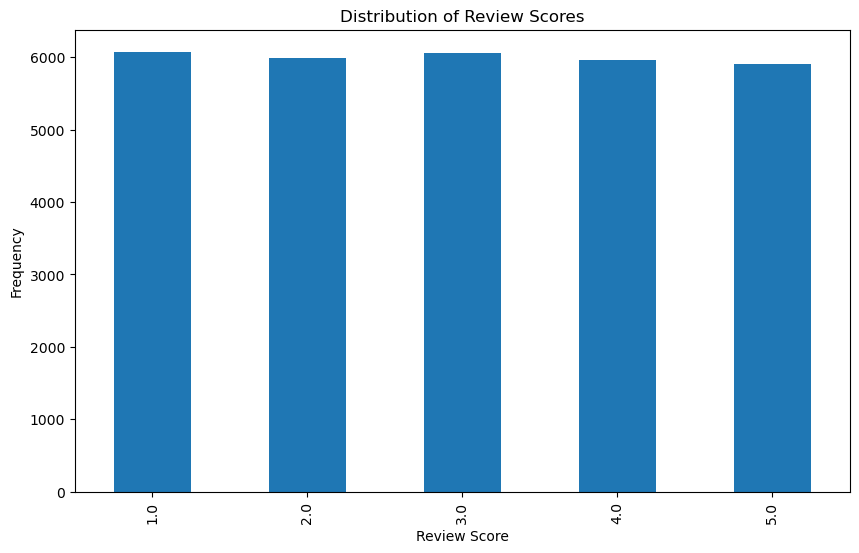

In [79]:

# Distribution of Review Scores
plt.figure(figsize=(10, 6))
balanced_df['review/score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

### Distribution of Binary Scores
- This bar chart presents the frequency of binary review scores, where original scores are converted into binary categories (0 = Negative for scores 1, 2, and 3; 1 = Positive for scores 4 and 5).

- There is a noticeable imbalance in the binary scores, with negative reviews (score 0) being more frequent than positive reviews (score 1).
This imbalance could impact the performance of classification models, making it essential to consider techniques such as class weighting or resampling to address this issue during model training.

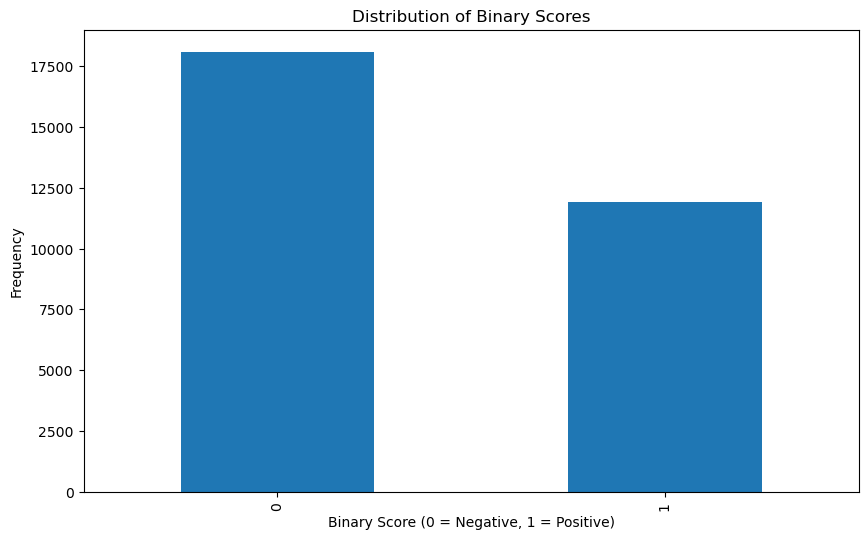

In [15]:
# Distribution of Binary Scores
plt.figure(figsize=(10, 6))
balanced_df['binary_score'].value_counts().plot(kind='bar')
plt.title('Distribution of Binary Scores')
plt.xlabel('Binary Score (0 = Negative, 1 = Positive)')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Clean text for EDA
def clean_text_simple(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

balanced_df['cleaned_review_simple'] = balanced_df['review/text'].apply(clean_text_simple)

C:\Users\James\AppData\Local\Temp\ipykernel_22404\2236693221.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


### WordCloud

-The word clouds below provide a visual representation of the most common words found in positive and negative book reviews. This helps us understand the key themes and elements that contribute to both positive and negative sentiments in the reviews.

1. __Positive:__ Story and Characters: Positive reviews frequently mention the "story" and "characters," indicating that readers appreciate well-crafted narratives and character development. Words like "life," "love," "time," and "great" suggest that positive reviews often highlight the enjoyment and impact the book had on the reader. Terms such as "well," "written," and "author" imply that the quality of writing and the author's storytelling abilities are important factors in positive reviews.

2. __Negative:__ Criticism of Story and Characters: Negative reviews also frequently mention "story" and "characters," but in a critical context, suggesting dissatisfaction with the plot or character development. The prominence of the word "author" in negative reviews may indicate that readers often attribute their disappointment directly to the writer. Words like "little," "know," and "much" may reflect common critiques related to the depth or execution of the story. Terms such as "read," "people," and "really" might be used in contexts where readers felt the book failed to engage or meet their expectations.

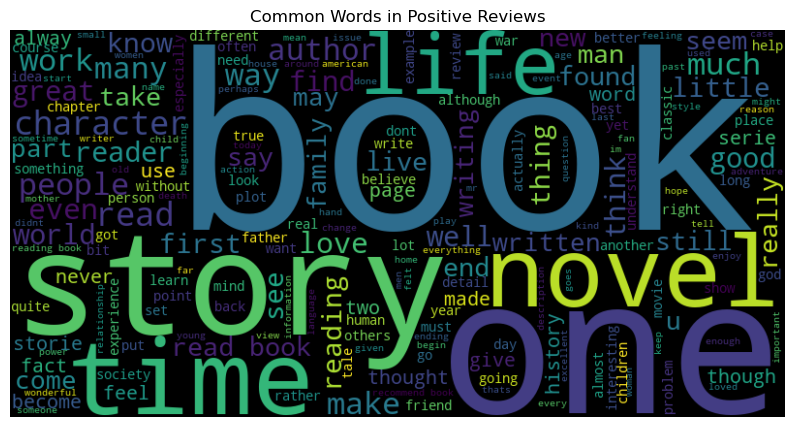

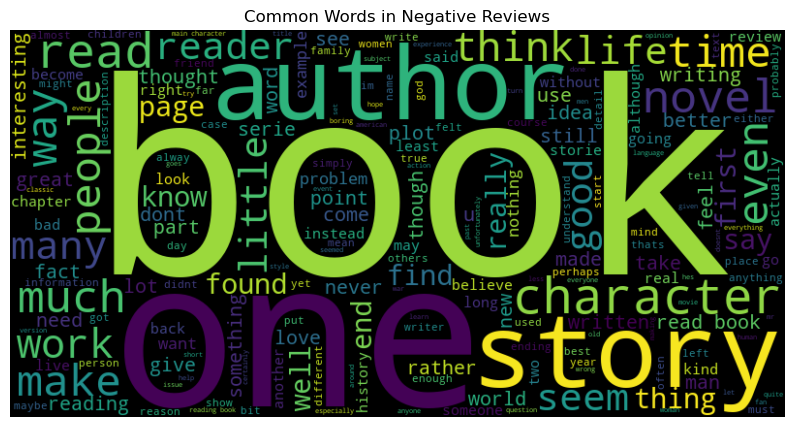

In [17]:
# WordClouds
positive_reviews = balanced_df[balanced_df['binary_score'] == 1]['cleaned_review_simple']
negative_reviews = balanced_df[balanced_df['binary_score'] == 0]['cleaned_review_simple']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

wordcloud_positive = WordCloud(width=800, height=400).generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Common Words in Positive Reviews')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Common Words in Negative Reviews')
plt.axis('off')
plt.show()

##### In this section, I preprocess the book review texts to prepare them for analysis and modeling. The function clean_text is designed to clean and standardize the text data, ensuring it is suitable for feature extraction and machine learning algorithms. Here’s a step-by-step explanation of what this function does:

In [80]:
# Data Preprocessing
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

balanced_df['cleaned_review'] = balanced_df['review/text'].apply(clean_text)

C:\Users\James\AppData\Local\Temp\ipykernel_22404\2907984043.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


## Modeling
I employed several machine learning models using scikit-learn and xgboost libraries. The models included Logistic Regression, Random Forest, and XGBoost. Hyperparameter tuning was performed using GridSearchCV and RandomizedSearchCV to optimize model performance. Logistic Regression was chosen for its simplicity and interpretability, Random Forest for its robustness and ability to handle feature importance, and XGBoost for its performance with imbalanced data. Sentiment analysis was conducted using TextBlob and VADER to gain qualitative insights.

In [81]:
# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

balanced_df['sentiment'] = balanced_df['cleaned_review'].apply(get_sentiment)

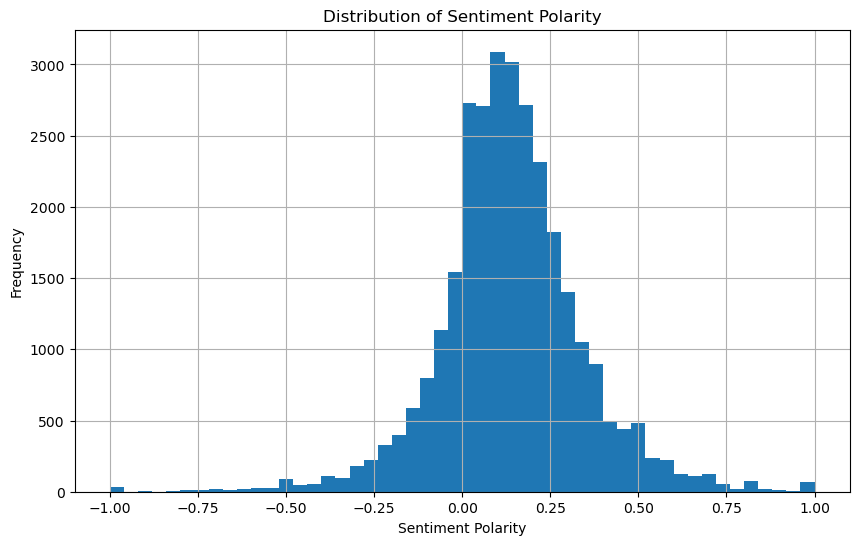

In [20]:
# Visualize Sentiment Distribution
plt.figure(figsize=(10, 6))
balanced_df['sentiment'].hist(bins=50)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

##### VIsualization function

Knowing that i would have multiple models, I created this function to make it quick to plot multiple visualizations for each model. The confusion matrix, ROC curve, and Recall curve will help us evaluate the models

In [82]:
# Function to plot confusion matrix for the models later
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to plot precision-recall curve
def plot_precision_recall_curve(precision, recall, title):
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

In [22]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(balanced_df['cleaned_review'], balanced_df['binary_score'], test_size=0.2, random_state=42)

# Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Logistic Regression

- I chose Logistic Regression for its simplicity, interpretability, and effectiveness in binary classification tasks. I used GridSearchCV to perform hyperparameter tuning, optimizing parameters such as C (inverse of regularization strength) and solver (algorithm to use in optimization). I tried multiple versions to find the best one. Multiple visuals were also combined with the models to be able evaluate the differences.

In [83]:
# Initial Logiistic Regression Model
model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)
y_pred_lr1 = model.predict(X_test_tfidf)

print("Classification Report:\n", classification_report(y_test, y_pred_lr1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr1))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      3667
           1       0.76      0.69      0.72      2333

    accuracy                           0.79      6000
   macro avg       0.79      0.78      0.78      6000
weighted avg       0.79      0.79      0.79      6000

Confusion Matrix:
 [[3150  517]
 [ 714 1619]]


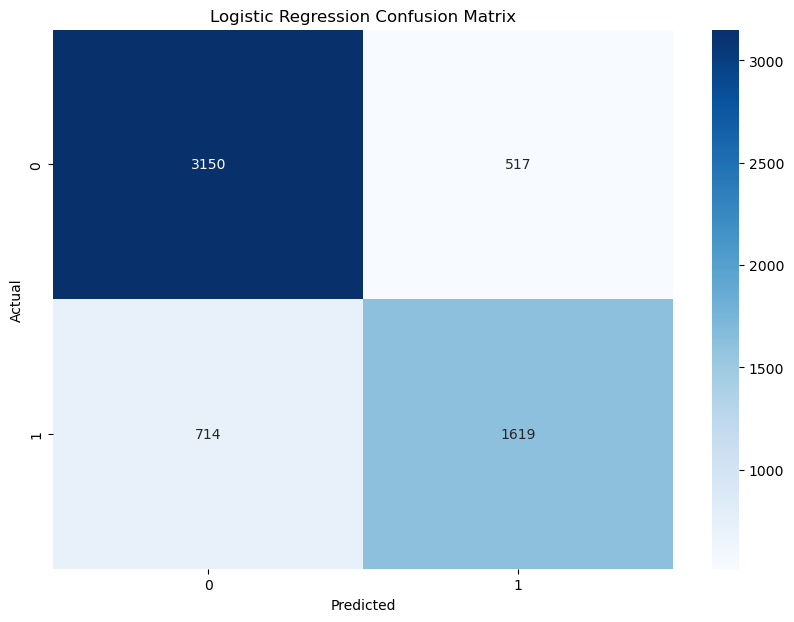

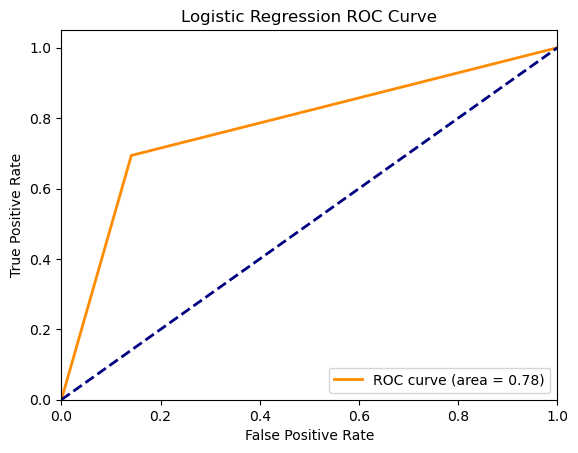

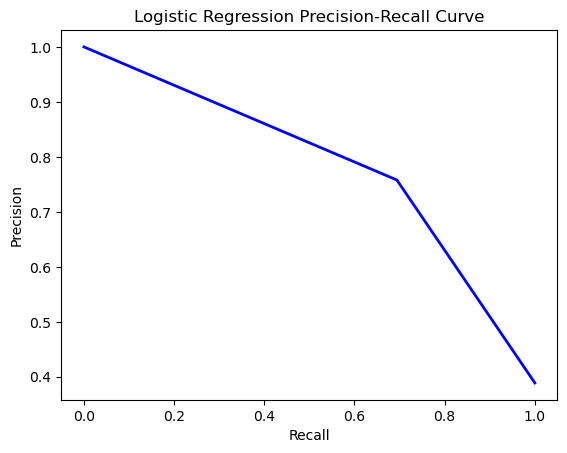

In [24]:
# Logistic Regression Visualization
model_name = "Logistic Regression"
y_test = y_test
y_pred_lr = y_pred_lr1


# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr)
plot_precision_recall_curve(precision_lr, recall_lr, f"{model_name} Precision-Recall Curve")

In [84]:
# New Model using StandardScaler
scaler = StandardScaler(with_mean=False)  # with_mean=False to work with sparse matrices
model_2 = make_pipeline(scaler, LogisticRegression(max_iter=1000))
model_2.fit(X_train_tfidf, y_train)
y_pred_lr2 = model_2.predict(X_test_tfidf)

print("Classification Report:\n", classification_report(y_test, y_pred_lr2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr2))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      3667
           1       0.68      0.69      0.68      2333

    accuracy                           0.75      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.75      0.75      0.75      6000

Confusion Matrix:
 [[2924  743]
 [ 731 1602]]


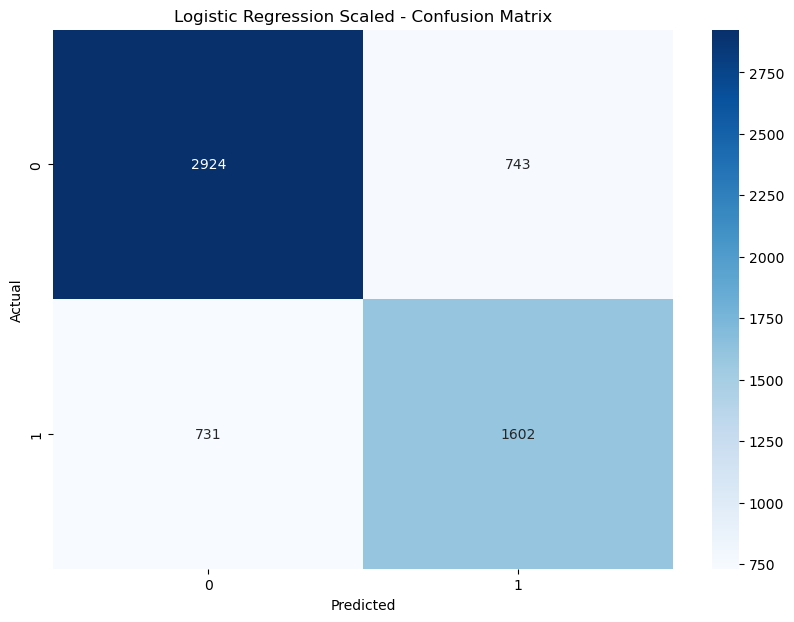

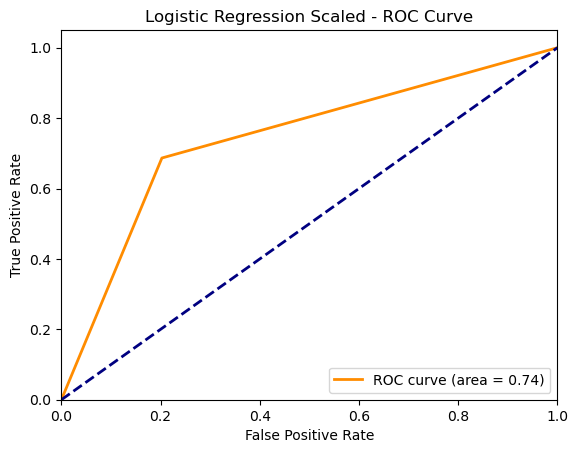

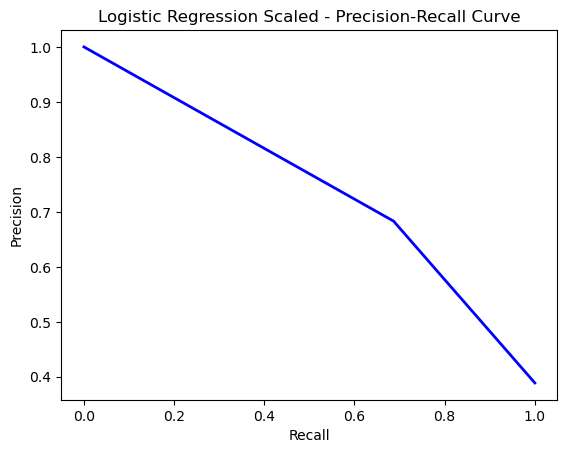

In [26]:
# Logistic Regression Visualization
model_name = "Logistic Regression Scaled -"
y_test = y_test
y_pred_lr = y_pred_lr2

# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr)
plot_precision_recall_curve(precision_lr, recall_lr, f"{model_name} Precision-Recall Curve")

In [85]:
# New model using GridSearchCV to hypertune the parameters to try to get the best model
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

model_3 = grid_search.best_estimator_
y_pred_lr3 = model_3.predict(X_test_tfidf)
y_prob_lr3 = model_3.predict_proba(X_test_tfidf)[:, 1]

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr3))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr3))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      3667
           1       0.76      0.69      0.72      2333

    accuracy                           0.79      6000
   macro avg       0.79      0.78      0.78      6000
weighted avg       0.79      0.79      0.79      6000

Logistic Regression Confusion Matrix:
 [[3150  517]
 [ 714 1619]]


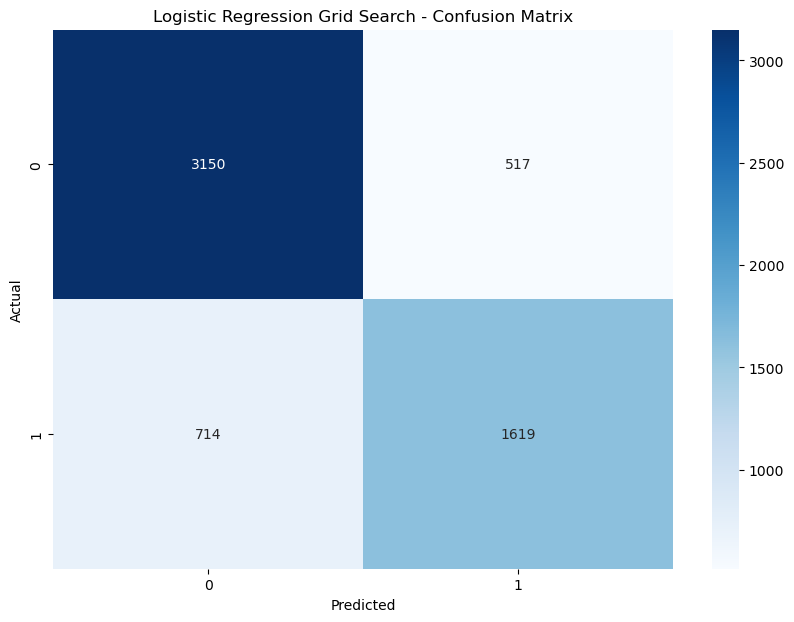

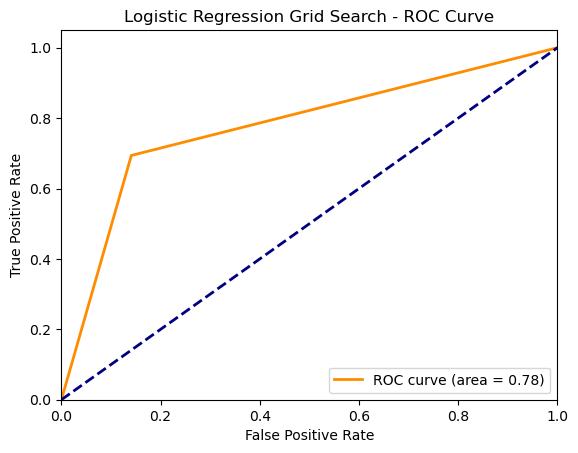

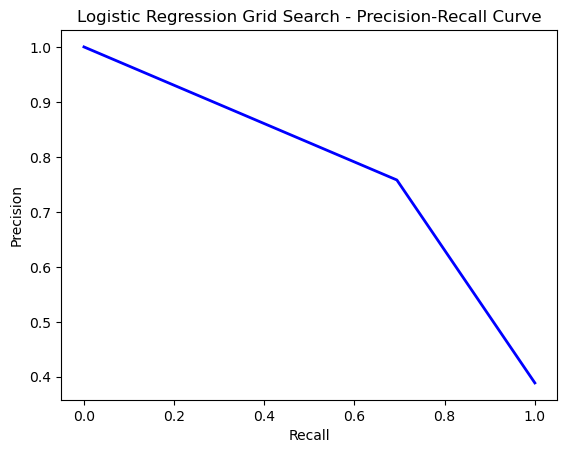

In [28]:
# Logistic Regression Visualization
model_name = "Logistic Regression Grid Search -"
y_test = y_test
y_pred_lr = y_pred_lr3

# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr3)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr3)
plot_precision_recall_curve(precision_lr, recall_lr, f"{model_name} Precision-Recall Curve")

In [86]:
# Using class_weights to try to deal with the slight class imbalance

model_weight = LogisticRegression(class_weight='balanced', max_iter=1000)
model_weight.fit(X_train_tfidf, y_train)
y_pred_weight = model_weight.predict(X_test_tfidf)

print("Classification Report:\n", classification_report(y_test, y_pred_weight))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_weight))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      3667
           1       0.70      0.79      0.74      2333

    accuracy                           0.79      6000
   macro avg       0.78      0.79      0.78      6000
weighted avg       0.80      0.79      0.79      6000

Confusion Matrix:
 [[2869  798]
 [ 480 1853]]


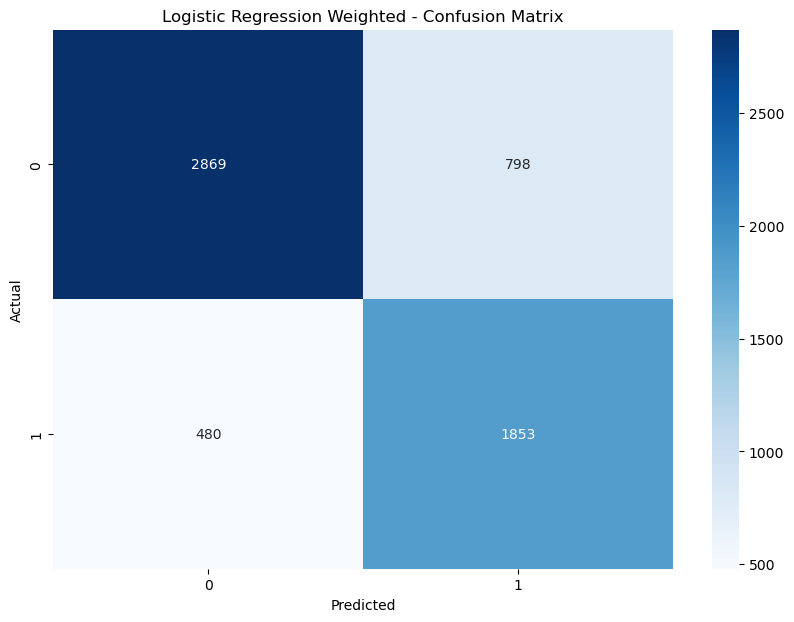

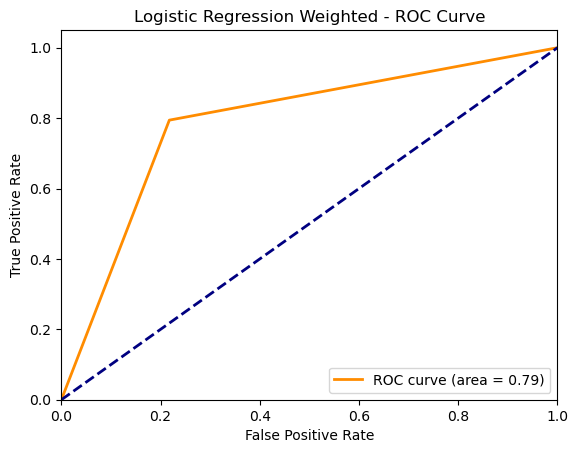

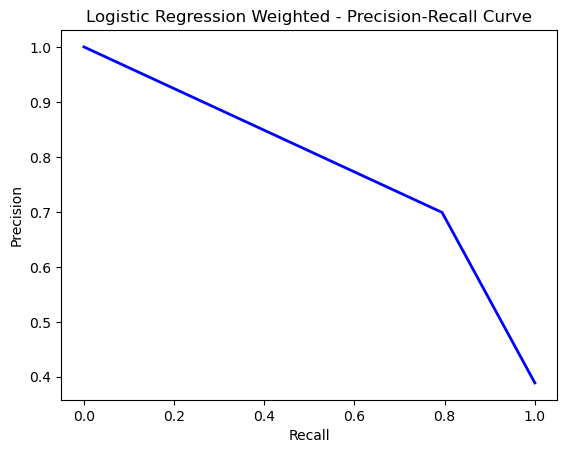

In [30]:
# Logistic Regression Visualization
model_name = "Logistic Regression Weighted -"
y_test = y_test
y_pred_lr = y_pred_weight

# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_weight)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_weight)
plot_precision_recall_curve(precision_lr, recall_lr, f"{model_name} Precision-Recall Curve")

In [87]:
# Using another method to try to handle the class imbalance
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

model_smote = LogisticRegression(class_weight='balanced', max_iter=1000)
model_smote.fit(X_train_resampled, y_train_resampled)
y_pred_smote = model_smote.predict(X_test_tfidf)

print("SMOTE Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_smote))
print("SMOTE Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))

SMOTE Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      3667
           1       0.71      0.78      0.74      2333

    accuracy                           0.79      6000
   macro avg       0.78      0.79      0.78      6000
weighted avg       0.79      0.79      0.79      6000

SMOTE Logistic Regression Confusion Matrix:
 [[2913  754]
 [ 517 1816]]


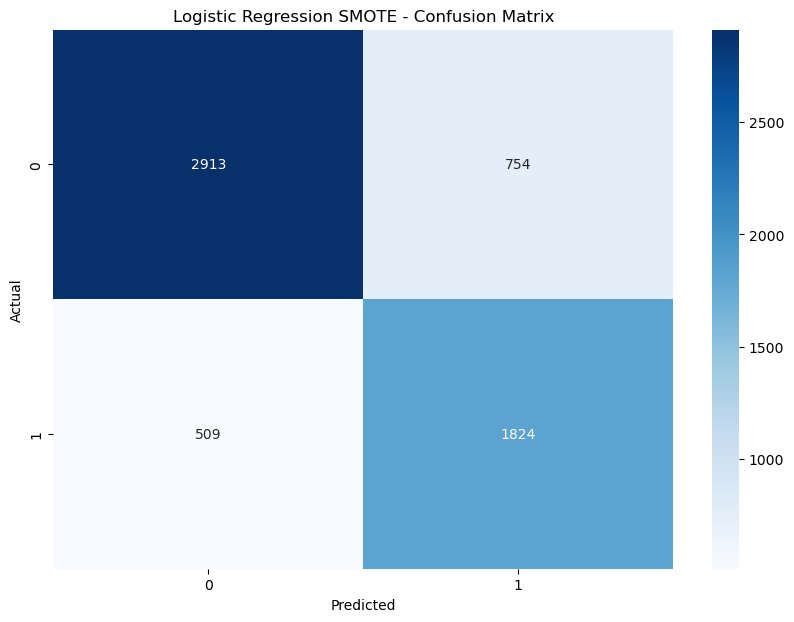

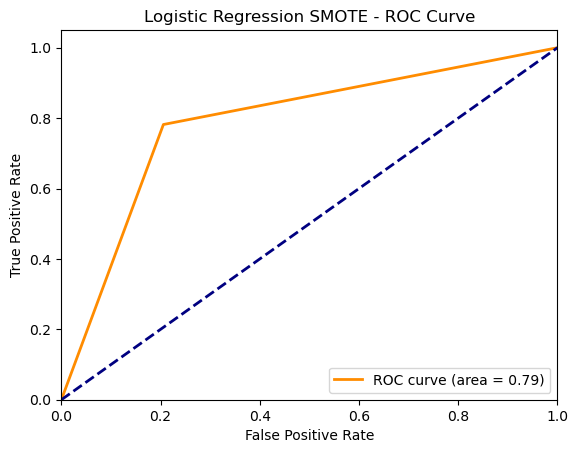

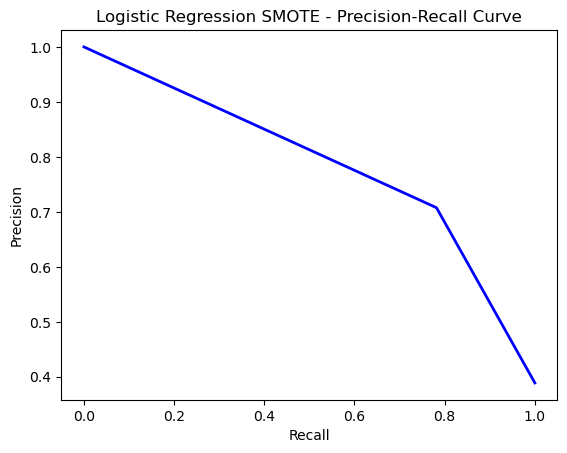

In [34]:
# Logistic Regression Visualization
model_name = "Logistic Regression SMOTE -"
y_test = y_test
y_pred_lr = y_pred_smote

# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_smote)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plot_roc_curve(fpr_lr, tpr_lr, roc_auc_lr, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_smote)
plot_precision_recall_curve(precision_lr, recall_lr, f"{model_name} Precision-Recall Curve")

### Random Forest

- Random Forest is known for its robustness and ability to handle complex data structures and feature importance evaluation. First I ran just a baseline model to see what the initial results would look like. Then used RandomizedSearchCV to perform hyperparameter tuning, optimizing parameters such as n_estimators (number of trees), max_depth (maximum depth of the tree), min_samples_split (minimum number of samples required to split an internal node), and class_weight (to handle class imbalance). These steps helped to increase the scores from the base model

In [88]:
# Initial Baseline random forest model
model_rf = RandomForestClassifier()
model_rf.fit(X_train_tfidf, y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      3667
           1       0.79      0.55      0.65      2333

    accuracy                           0.77      6000
   macro avg       0.78      0.73      0.74      6000
weighted avg       0.77      0.77      0.76      6000

Random Forest Confusion Matrix:
 [[3324  343]
 [1044 1289]]


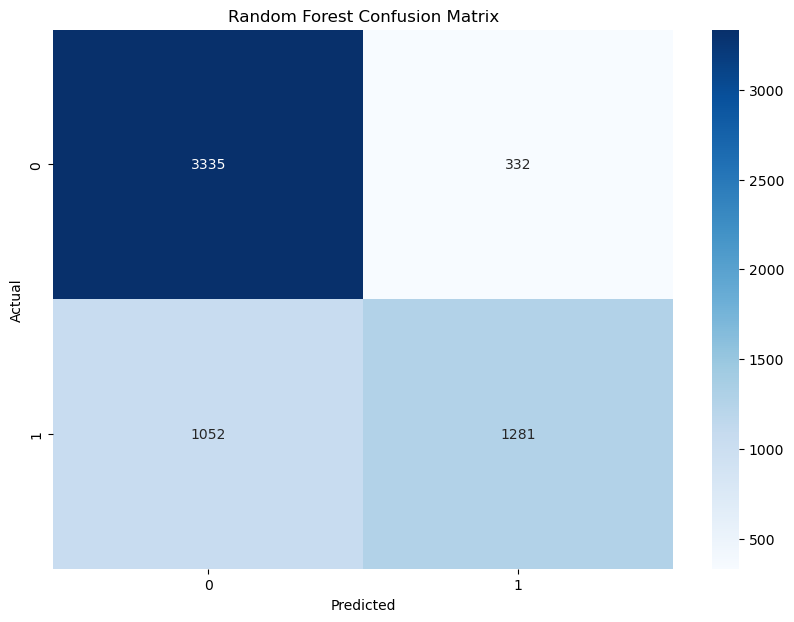

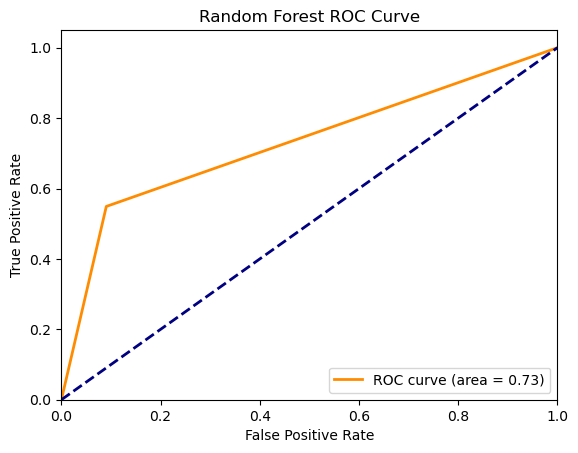

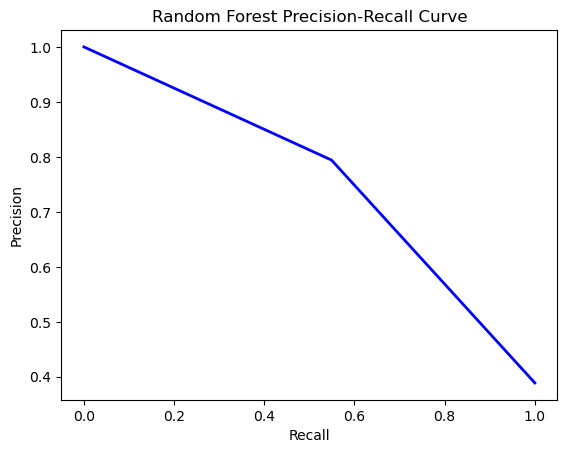

In [36]:
model_name = "Random Forest"
y_test = y_test
y_pred_rf = y_pred_rf

# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plot_roc_curve(fpr_rf, tpr_rf, roc_auc_rf, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
plot_precision_recall_curve(precision_rf, recall_rf, f"{model_name} Precision-Recall Curve")

In [89]:
# New Model using GridSearchCV to hypertune parameters and use cross-validation

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_tfidf, y_train)

rf_2 = grid_search_rf.best_estimator_
y_pred_rf_2 = rf_2.predict(X_test_tfidf)

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_2))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_2))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81      3667
           1       0.84      0.39      0.53      2333

    accuracy                           0.73      6000
   macro avg       0.78      0.67      0.67      6000
weighted avg       0.76      0.73      0.70      6000

Random Forest Confusion Matrix:
 [[3501  166]
 [1434  899]]


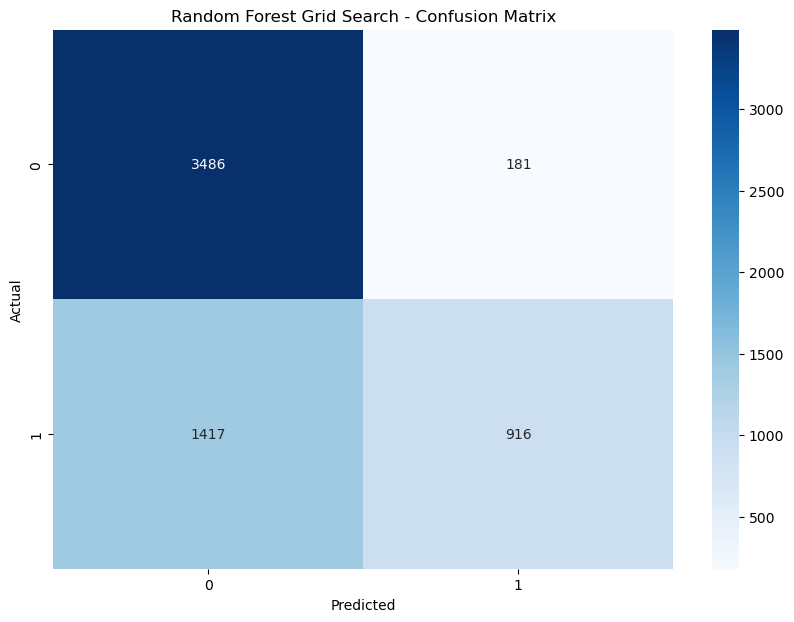

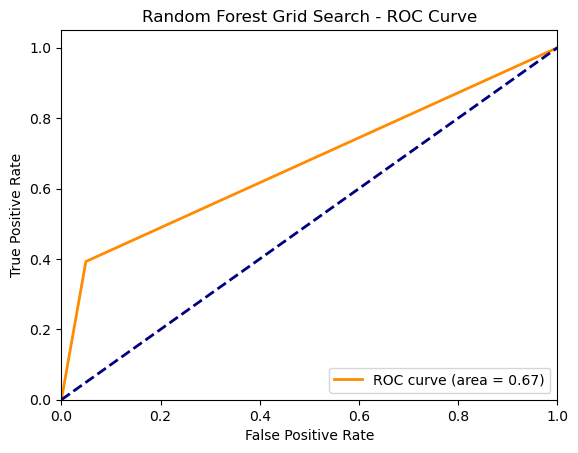

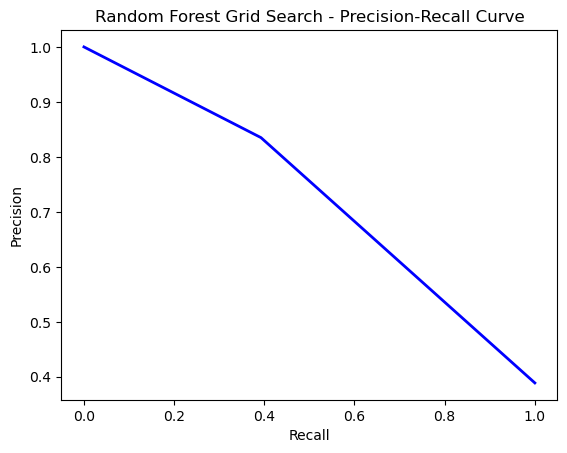

In [38]:
model_name = "Random Forest Grid Search -"
y_test = y_test
y_pred_rf = y_pred_rf_2

# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_2)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plot_roc_curve(fpr_rf, tpr_rf, roc_auc_rf, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf_2)
plot_precision_recall_curve(precision_rf, recall_rf, f"{model_name} Precision-Recall Curve")

In [90]:
# Used RandomizedSearchCv combined with adding class weight to try to deal with imbalance
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']  # Add class_weight to handle imbalance
}

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist_rf,
    n_iter=10,  # Number of random parameter combinations to try
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit the model
random_search_rf.fit(X_train_tfidf, y_train)

# Get the best estimator
best_rf = random_search_rf.best_estimator_

# Predict on the test set
y_pred_best_rf = best_rf.predict(X_test_tfidf)

# Print the results
print("Best Random Forest Classification Report:\n", classification_report(y_test, y_pred_best_rf))
print("Best Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))

Best Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80      3667
           1       0.68      0.70      0.69      2333

    accuracy                           0.75      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.76      0.75      0.75      6000

Best Random Forest Confusion Matrix:
 [[2890  777]
 [ 702 1631]]


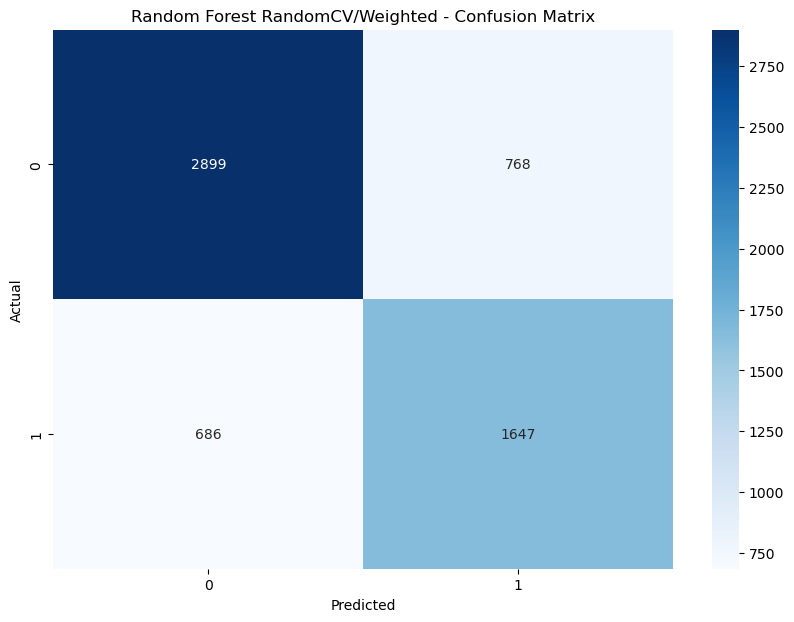

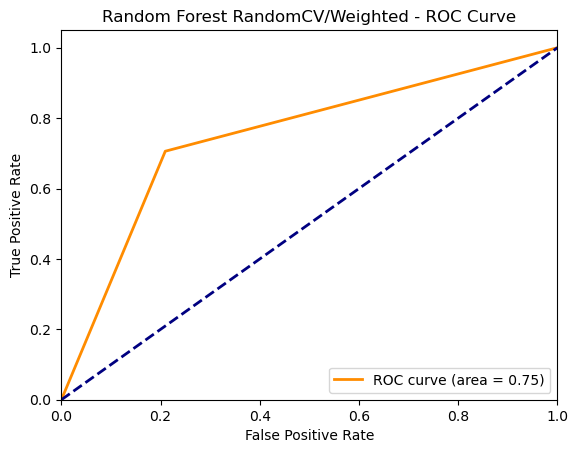

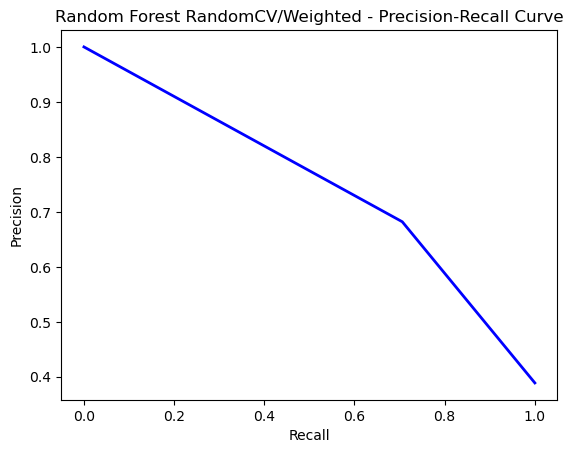

In [40]:
model_name = "Random Forest RandomCV/Weighted -"
y_test = y_test
y_pred_rf = y_pred_best_rf

# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_best_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plot_roc_curve(fpr_rf, tpr_rf, roc_auc_rf, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_best_rf)
plot_precision_recall_curve(precision_rf, recall_rf, f"{model_name} Precision-Recall Curve")

In [92]:
# Tried gradientboosting but when tuning hyperparameters it ran for many many hours so decided against it
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train_tfidf, y_train)
y_pred_gb = model_gb.predict(X_test_tfidf)

print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Gradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.91      0.81      3667
           1       0.76      0.46      0.57      2333

    accuracy                           0.73      6000
   macro avg       0.74      0.68      0.69      6000
weighted avg       0.74      0.73      0.71      6000

Gradient Boosting Confusion Matrix:
 [[3321  346]
 [1262 1071]]


### XGBoost
- I chose to use XGBoost for its high performance and ability to handle imbalanced datasets effectively. RandomizedSearchCV was also used here to perform hyperparameter tuning, optimizing parameters such as n_estimators (number of trees), max_depth (maximum depth of the tree), learning_rate (shrinkage rate), and scale_pos_weight (to handle class imbalance).

In [42]:

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 3]  # Handling imbalance
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False),
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_tfidf, y_train)

xgb = random_search_xgb.best_estimator_
y_pred_xgb = xgb.predict(X_test_tfidf)

print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79      3667
           1       0.66      0.81      0.73      2333

    accuracy                           0.76      6000
   macro avg       0.76      0.77      0.76      6000
weighted avg       0.78      0.76      0.77      6000

XGBoost Confusion Matrix:
 [[2688  979]
 [ 435 1898]]


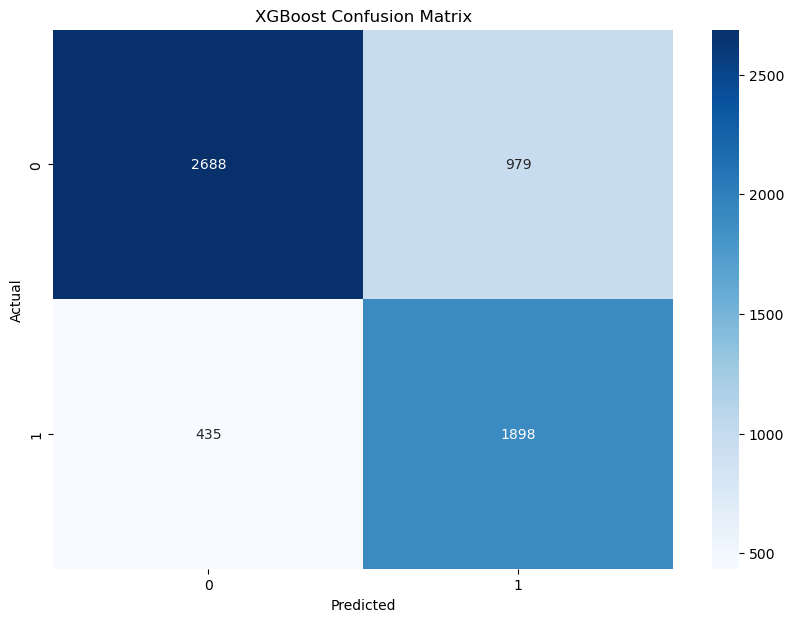

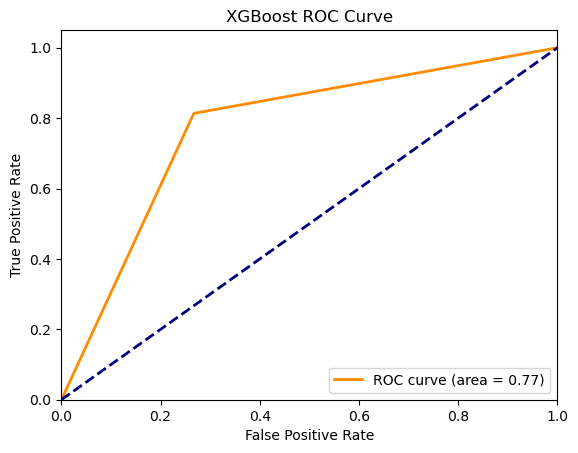

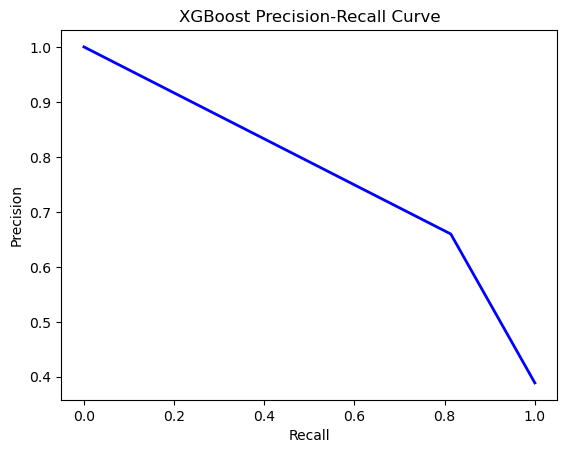

In [43]:
# XGBoost Visualization
model_name = "XGBoost"
y_test = y_test
y_pred_xgb =y_pred_xgb


# Plot confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(cm_xgb, f"{model_name} Confusion Matrix")

# Calculate and plot ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plot_roc_curve(fpr_xgb, tpr_xgb, roc_auc_xgb, f"{model_name} ROC Curve")

# Calculate and plot Precision-Recall curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)
plot_precision_recall_curve(precision_xgb, recall_xgb, f"{model_name} Precision-Recall Curve")

In [44]:
def get_textblob_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity

def get_vader_sentiment(review):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(review)
    return vs['compound']



In [68]:
# Apply sentiment analysis to the test set
balanced_df_test = balanced_df.iloc[y_test.index].copy()

# Apply sentiment analysis functions
balanced_df_test['textblob_sentiment'] = balanced_df_test['review/text'].apply(get_textblob_sentiment)
balanced_df_test['vader_sentiment'] = balanced_df_test['review/text'].apply(get_vader_sentiment)

# Convert sentiment categories to binary
def categorize_sentiment_binary(score):
    return 1 if score > 0 else 0

balanced_df_test['textblob_sentiment_binary'] = balanced_df_test['textblob_sentiment'].apply(categorize_sentiment_binary)
balanced_df_test['vader_sentiment_binary'] = balanced_df_test['vader_sentiment'].apply(categorize_sentiment_binary)

# Function to print metrics
def print_metrics(y_true, y_pred, model_name):
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.2f}\n")

# Print metrics for models
print_metrics(y_test, y_pred_lr3, "Logistic Regression")
print_metrics(y_test, y_pred_best_rf, "Random Forest")
print_metrics(y_test, y_pred_xgb, "XGBoost")

# Print metrics for sentiment analysis
print_metrics(y_test, balanced_df_test['textblob_sentiment_binary'], "TextBlob Sentiment (Binary)")
print_metrics(y_test, balanced_df_test['vader_sentiment_binary'], "VADER Sentiment (Binary)")

Metrics for Logistic Regression:
Accuracy: 0.79
Precision: 0.76
Recall: 0.69
F1-Score: 0.72

Metrics for Random Forest:
Accuracy: 0.76
Precision: 0.68
Recall: 0.71
F1-Score: 0.69

Metrics for XGBoost:
Accuracy: 0.76
Precision: 0.66
Recall: 0.81
F1-Score: 0.73

Metrics for TextBlob Sentiment (Binary):
Accuracy: 0.43
Precision: 0.39
Recall: 0.81
F1-Score: 0.52

Metrics for VADER Sentiment (Binary):
Accuracy: 0.45
Precision: 0.39
Recall: 0.71
F1-Score: 0.50



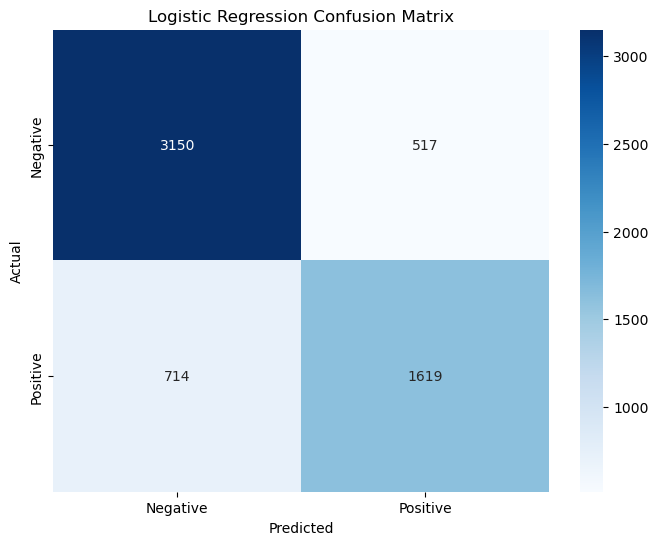

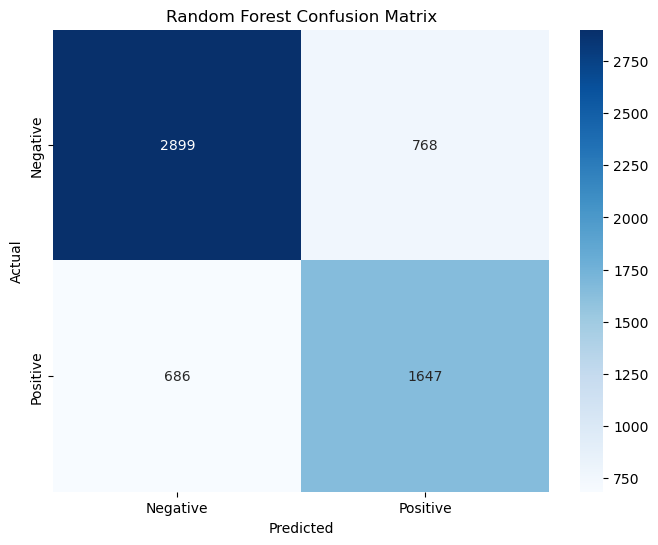

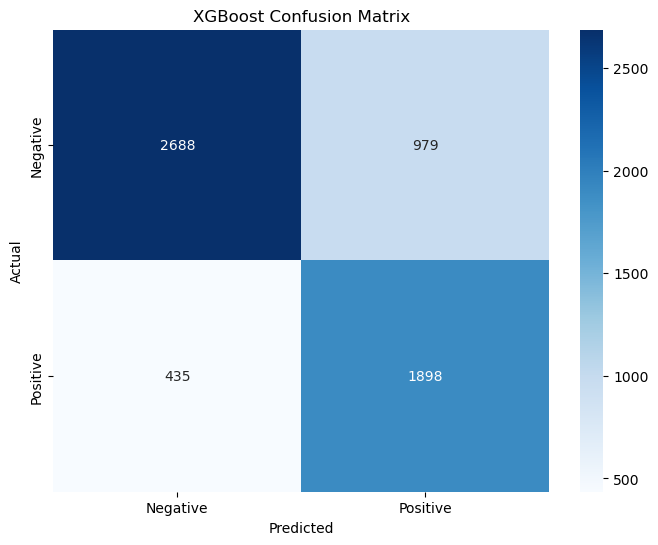

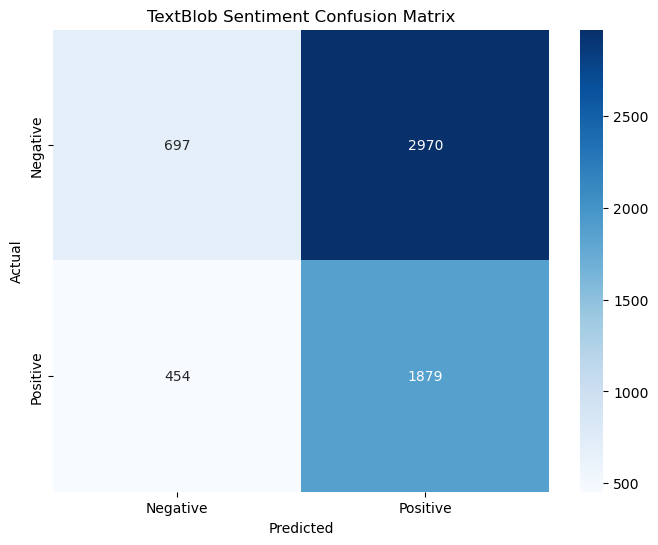

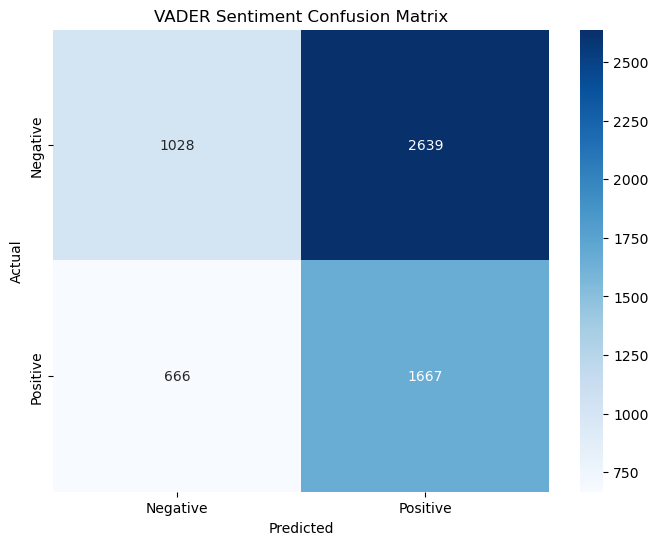

In [71]:
# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrices for models and sentiment analysis
plot_confusion_matrix(y_test, y_pred_lr3, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_best_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

plot_confusion_matrix(y_test, balanced_df_test['textblob_sentiment_binary'], "TextBlob Sentiment Confusion Matrix")
plot_confusion_matrix(y_test, balanced_df_test['vader_sentiment_binary'], "VADER Sentiment Confusion Matrix")

## Evaluation

##### The final models were evaluated using accuracy, precision, recall, and F1-score. The best Logistic Regression achieved an accuracy of 0.79, with a precision of 0.76, recall of 0.69, and F1-score of 0.72. The best Random Forest showed an accuracy of 0.76, precision of 0.68, recall of 0.71, and F1-score of 0.69. XGBoost achieved an accuracy of 0.76, precision of 0.66, recall of 0.81, and F1-score of 0.73. The sentiment analysis models, TextBlob and VADER, had lower accuracies of 0.43 and 0.45, respectively, indicating they are better suited for qualitative insights rather than quantitative predictions. The validation approach involved splitting the data into training and test sets and using cross-validation to ensure robustness and reliability of the models.

## Rationale
##### The rationale for this approach was to leverage customer reviews to enhance Amazon's recommendation system and gain insights into customer satisfaction. By combining sentiment analysis with predictive modeling, we aimed to provide a comprehensive solution that addresses both qualitative and quantitative aspects of customer feedback.

## Limitations

##### While sentiment analysis provided valuable insights, it struggled with precision, highlighting the need for more sophisticated NLP models or additional data for training. Additionally, the imbalance in the dataset affected model performance, particularly in terms of precision and recall. Also the size of the dataset make it computationally intensive. So while there was a lot more data there to be used,it was difficult to use it

# Recommendations for Amazon

1. __Improve Product Recommendations__

    - __What to Do:__ Use the Logistic Regression model to predict how likely customers are to rate a product positively based on their reviews.

    - __Why:__ This model provides reliable predictions, helping to recommend products that customers are more likely to love, enhancing their shopping experience.


2.  __Target Satisfied Customers for Testimonials and Promotions__

    -  __What to Do:__ Utilize the XGBoost model to identify highly satisfied customers who can provide testimonials or be targeted for promotional campaigns.
    
    - __Why:__ This model is excellent at identifying happy customers, allowing Amazon to leverage positive feedback for marketing purposes and build a stronger brand reputation.  

3. __Identify and Address Common Customer Issues__

    - __What to Do:__ Use sentiment analysis tools like TextBlob and VADER to analyze customer reviews for common issues or complaints.
    
    - __Why:__ Understanding the common pain points in customer reviews helps in making targeted improvements to products and services, leading to increased customer satisfaction and loyalty.     

## Next Steps

1. __Invest in Advanced Text Analysis Tools__

    - __What to Do:__ Explore advanced Natural Language Processing (NLP) models like BERT to further improve sentiment analysis accuracy.
    
    - __Why:__ More sophisticated models can provide deeper insights into customer sentiments, leading to better decision-making and more precise targeting of customer needs.
2. __Continuous Model Improvement__

    - __What to Do:__ Regularly update and fine-tune the predictive models with new data to maintain their accuracy and effectiveness.
    
    - __Why:__ Keeping models up-to-date ensures they continue to provide accurate predictions, adapting to changing customer preferences and behaviors.    